In [3]:
from pscore_data_reader_preproc import read_and_process_data, model_evaluation
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Read in the data using the pre-processing code
x_train, y_train, x_test, y_test, train_team_values, test_team_values = read_and_process_data(
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_train_data.csv",
     r"E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\scripts_and_data\data\score_pred_test_data.csv",
     True
)

# check to make sure the data looks right
x_train.shape
x_test.shape

train data has shape: (14648, 490)
test data has shape: (132, 490)


(132, 490)

In [5]:
# Step 1: Define hyperparameter grid
n_estimator_values = [50, 100, 200]  # Number of trees in the forest
max_depth_values = [None, 10, 20, 30]  # Maximum depth of the tree
max_features_values = ['auto', 'sqrt', 'log2']  # Number of features to consider at each split

# Step 2: Create the parameter grid
rf_param_grid = {
    'n_estimators': n_estimator_values,
    'max_depth': max_depth_values,
    'max_features': max_features_values
}

# Step 3: set up regressor
rf_regressor = RandomForestRegressor()

# Step 4: fit the grid search model
rf_grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=rf_param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as the scoring metric
    n_jobs=-3,  # Use all available cores minus 2
    verbose=1  # Output progress
)

In [6]:
# fit the grid search
rf_grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\github_repos\Private_Projects\NCAA_FBS_AP_Ranking_Predictions\python_ap\venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "E:\github_re

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-3,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

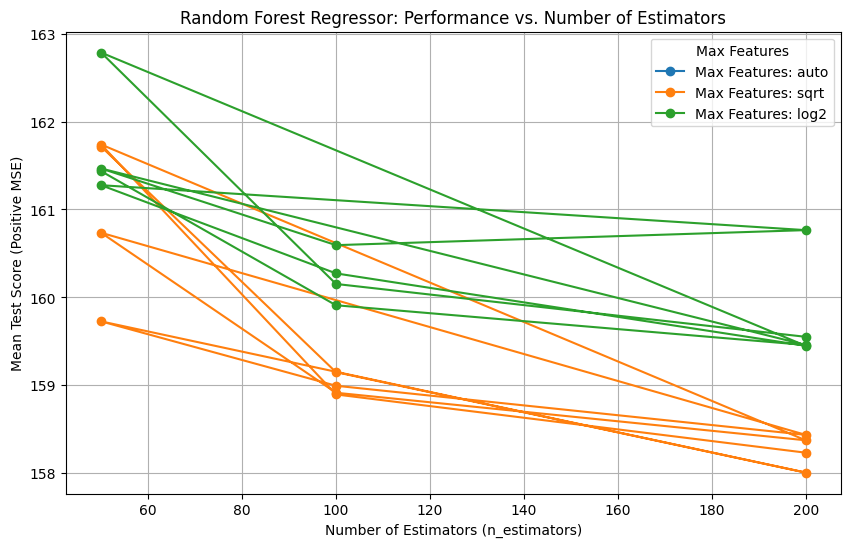

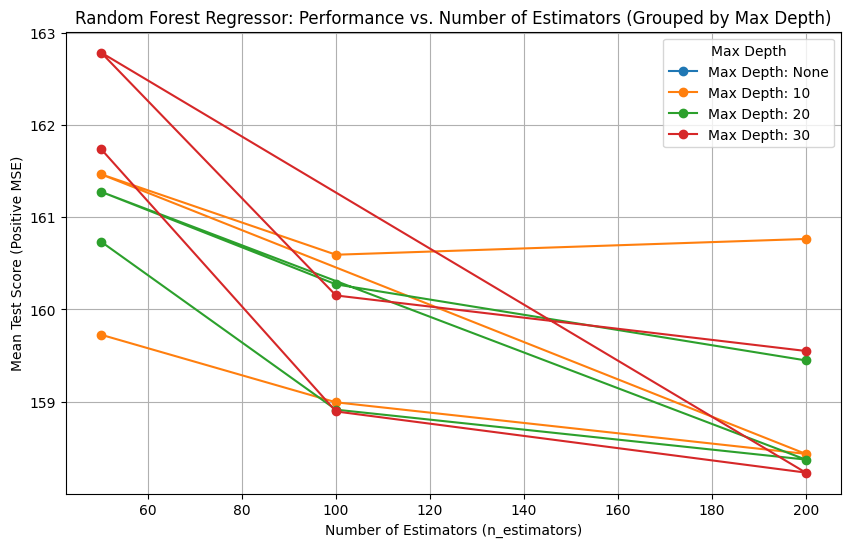

In [8]:
# Extract results from GridSearchCV
rf_results = pd.DataFrame(rf_grid_search.cv_results_)

# Plot performance for different max_features grouped by n_estimators
plt.figure(figsize=(10, 6))

for max_feature in max_features_values:  # max_features: ['auto', 'sqrt', 'log2']
    subset = rf_results[rf_results['param_max_features'] == max_feature]
    plt.plot(
        subset['param_n_estimators'], 
        -subset['mean_test_score'],  # Convert Negative MSE to Positive MSE
        marker='o', 
        label=f'Max Features: {max_feature}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Positive MSE)')
plt.title('Random Forest Regressor: Performance vs. Number of Estimators')
plt.legend(title='Max Features')
plt.grid()
plt.show()

# Optional: Plot performance for different max_depth values
plt.figure(figsize=(10, 6))

for max_depth in max_depth_values:  # max_depth: [None, 10, 20, 30]
    subset = rf_results[rf_results['param_max_depth'] == max_depth]
    plt.plot(
        subset['param_n_estimators'], 
        -subset['mean_test_score'],  # Convert Negative MSE to Positive MSE
        marker='o', 
        label=f'Max Depth: {max_depth}'
    )

# Customize the plot
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Mean Test Score (Positive MSE)')
plt.title('Random Forest Regressor: Performance vs. Number of Estimators (Grouped by Max Depth)')
plt.legend(title='Max Depth')
plt.grid()
plt.show()

In [11]:
# Get the best parameters
best_n_estimator_value = rf_grid_search.best_params_['n_estimators']
best_max_depth_value = rf_grid_search.best_params_['max_depth']
best_max_features_value = rf_grid_search.best_params_['max_features']

# Print the best values
print(f"Best n_estimators: {best_n_estimator_value}")
print(f"Best max_depth: {best_max_depth_value}")
print(f"Best max_features: {best_max_features_value}")


Best n_estimators: 200
Best max_depth: None
Best max_features: sqrt


In [12]:
# fit final model using the best param
best_rf_regressor = RandomForestRegressor(
    n_estimators=best_n_estimator_value,
    max_depth=best_max_depth_value,
    max_features=best_max_features_value
)

best_rf_regressor.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200)

In [13]:
# Model evaluation
y_pred_train = best_rf_regressor.predict(x_train)

# evaluate model
model_evaluation(y_train, y_pred_train)

R-squared: 0.891
Mean Squared Error (MSE): 21.366
Mean Absolute Error (MAE): 3.704


In [14]:
y_pred_test = best_rf_regressor.predict(x_test)
x_test['predictions'] = y_pred_test
x_test['actual'] = y_test
x_test = pd.concat([x_test, test_team_values], axis=1)
x_test.to_csv("test_test.csv")